That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [1]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

 /u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [3]:
#fname = '/u/ki/swmclau2/des/PearceMCMC/HOD_vdf_rmin_None_HOD.hdf5'
fname = '/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_0.5_HOD.hdf5'

In [4]:
f = h5py.File(fname, 'r')

In [5]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [6]:
tf

array(['/u/ki/swmclau2/des/Aemulators/wp_zheng07/PearceWpCosmo.hdf5',
       '/u/ki/swmclau2/des/Aemulators/ds_zheng07/PearceDsCosmo.hdf5'],
      dtype='|S59')

In [7]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/wp_zheng07/PearceWpCosmo.hdf5
/u/ki/swmclau2/des/Aemulators/ds_zheng07/PearceDsCosmo.hdf5


In [8]:
chain_pnames = f.attrs['param_names']

In [9]:
n_walkers = f.attrs['nwalkers']

In [10]:
n_burn = 1000
chain = f['chain'][n_burn*n_walkers:, :]

In [11]:
rmin = eval(f.attrs['fixed_params'])['rmin'] if 'rmin' in f.attrs['fixed_params'] else 0

In [12]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [13]:
print chain.shape, chain.shape[0]/n_walkers

(6177250, 12) 24709


In [14]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers)


In [15]:
#MAP = chain.mean(axis = 0)
summary = c.analysis.get_summary(chains=0)
MAP = np.array([summary[key][1] for key in chain_pnames])
print MAP

[ 2.18687599e-02  1.22916883e-01 -7.99278608e-01  9.79299448e-01
  7.11110170e+01  2.62645651e+00  8.74241348e-01  1.41531024e+01
  1.31672107e+01  2.75134919e-01  1.07438013e+00  1.59453719e+00]


In [16]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [17]:
MAP_dict = dict(zip(chain_pnames, MAP))

In [18]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [19]:
MAP_dict.update(fixed_params)

In [20]:
MAP_dict

{'H0': 71.11101702698983,
 'Neff': 2.6264565082258016,
 'alpha': 1.0743801251125065,
 'conc_gal_bias': 1.5945371850689702,
 'logM0': 13.167210700524093,
 'logM1': 14.153102364542466,
 'ns': 0.9792994478307064,
 'ombh2': 0.021868759914671777,
 'omch2': 0.12291688313363339,
 'sigma8': 0.8742413475116325,
 'sigma_logM': 0.275134919075714,
 'w0': -0.7992786080494436,
 'z': 0.0}

In [21]:
MAP_pred = np.hstack([emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
MAP_pred = MAP_pred.reshape((len(emus), -1))

In [22]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [23]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [24]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [25]:
cosmo_params['boxno'] = 1
cosmo_params['realization'] = 0

In [26]:
cat = cat_dict['testbox'](**cosmo_params)#construct the specified catalog!

In [27]:
cpv = cat._get_cosmo_param_names_vals()

cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}

In [28]:
cat_val_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'w0': -0.861513}

In [29]:
true_param_dict = cat_val_dict.copy()
hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
#hod_params = {'alpha': 1.03887697, 'conc_gal_bias': 1.0, 'logM0': 11.41003864,\
#              'logM1': 14.56088772, 'sigma_logM': 0.44415644}#sim_info['hod_params']



#hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_param1'] =0.0
#hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0
#hod_params['mean_occupation_centrals_assembias_corr1'] = 0.0
#hod_params['mean_occupation_satellites_assembias_corr1'] =0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [30]:
true_param_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'sigma_logM': 0.2,
 'w0': -0.861513}

In [31]:
true_data = f['data'][()]#.flatten()

In [32]:
true_data = true_data.reshape((len(emus), -1))

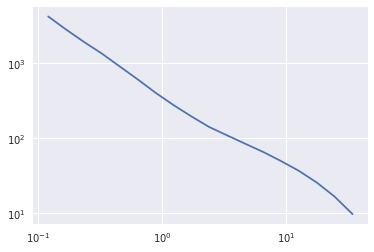

In [33]:
plt.plot(emu.scale_bin_centers, true_data[0])
#plt.plot(emu.scale_bin_centers, true_data[1])

plt.loglog();

In [34]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [35]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov)).reshape((len(emus), -1))

In [36]:
true_data[0]

array([4175.84889774, 2796.76726807, 1913.37019631, 1338.06799577,
        900.93561824,  607.5341018 ,  402.66248591,  276.30088782,
        195.3036026 ,  140.83841875,  109.11924002,   84.62075765,
         65.86609395,   49.80634817,   36.88111703,   25.7700211 ,
         16.71764453,    9.78011813])

In [37]:
yerr[0]/true_data[0]

array([0.16945535, 0.13126948, 0.07860621, 0.04447019, 0.02890912,
       0.04023796, 0.05245378, 0.05082986, 0.04134687, 0.03323574,
       0.02741307, 0.02450939, 0.02208323, 0.02349841, 0.02661884,
       0.03234006, 0.04253213, 0.06326229])

In [38]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [39]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

In [40]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

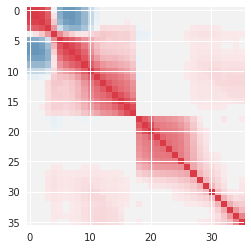

In [41]:
plt.imshow(cov_to_corr(cov ) , cmap=cmap, vmin = -1)

In [42]:
true_data

array([[4.17584890e+03, 2.79676727e+03, 1.91337020e+03, 1.33806800e+03,
        9.00935618e+02, 6.07534102e+02, 4.02662486e+02, 2.76300888e+02,
        1.95303603e+02, 1.40838419e+02, 1.09119240e+02, 8.46207577e+01,
        6.58660939e+01, 4.98063482e+01, 3.68811170e+01, 2.57700211e+01,
        1.67176445e+01, 9.78011813e+00],
       [8.20626475e+01, 6.58215973e+01, 5.15299728e+01, 3.94055621e+01,
        2.95573292e+01, 2.17734344e+01, 1.57719303e+01, 1.12185065e+01,
        7.79230941e+00, 5.28055637e+00, 3.47557528e+00, 2.25393185e+00,
        1.50906895e+00, 1.06553235e+00, 7.83221868e-01, 6.22334014e-01,
        5.02679278e-01, 3.91403290e-01]])

In [43]:
true_param_dict

{'H0': 65.7317,
 'Neff': 3.2,
 'alpha': 1.083,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.2,
 'ns': 0.971515,
 'ombh2': 0.022762900000000003,
 'omch2': 0.11283,
 'sigma8': 0.7542319000000001,
 'sigma_logM': 0.2,
 'w0': -0.861513}

In [44]:
true_data[0]

array([4175.84889774, 2796.76726807, 1913.37019631, 1338.06799577,
        900.93561824,  607.5341018 ,  402.66248591,  276.30088782,
        195.3036026 ,  140.83841875,  109.11924002,   84.62075765,
         65.86609395,   49.80634817,   36.88111703,   25.7700211 ,
         16.71764453,    9.78011813])

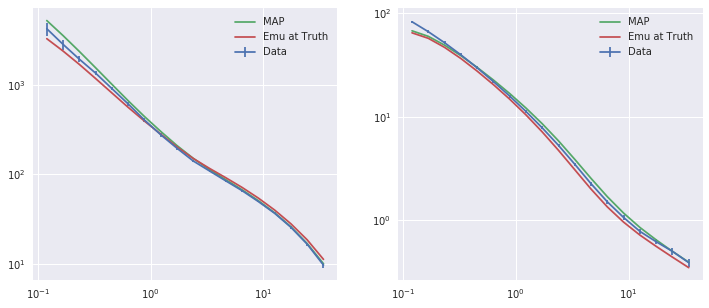

In [45]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    plt.plot(rbc, 10**MAP_pred[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred), label = 'Emu at Truth')

    plt.loglog()
    plt.legend(loc='best')
plt.show();

In [46]:
rmin_idxs = rbc > rmin

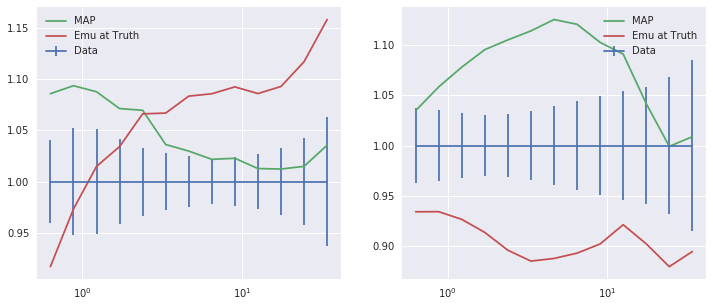

In [47]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc[rmin_idxs], np.ones_like(true_data[i][rmin_idxs]), yerr=yerr[i][rmin_idxs]/true_data[i][rmin_idxs], label = 'Data')
    plt.plot(rbc[rmin_idxs], (10**MAP_pred[i][rmin_idxs])/true_data[i][rmin_idxs], label = 'MAP')
    plt.plot(rbc[rmin_idxs], (10**true_pred[rmin_idxs])/true_data[i][rmin_idxs], label = 'Emu at Truth')
    plt.legend(loc='best')
    plt.xscale('log')
plt.show();

In [48]:
emu.obs

'ds'

In [49]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [50]:
npart_aemulus = 1400**3
npart_mdpl2 = 3840**3

downsample_factor = 1e-2
npart_aemulus_ds = npart_aemulus*downsample_factor
print npart_aemulus_ds, npart_aemulus_ds/npart_mdpl2

27440000.0 0.000484607837818


In [51]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'logM1',
       'logM0', 'sigma_logM', 'alpha', 'conc_gal_bias'], dtype='|S13')

In [52]:
true_pred = np.hstack([emu.emulate_wrt_r(true_param_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
true_pred = true_pred.reshape((len(emus), -1))

In [53]:
cov_rmin_idxs = np.hstack([rmin_idxs for i in xrange(len(emus))])

In [54]:
print 'True Red. Chi2'
R = (10**true_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

True Red. Chi2
5.595359786952229


In [55]:
print 'Map Red. Chi2'
R = (10**MAP_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

Map Red. Chi2
2.8553341600408864


In [56]:
N = 6
cmap = sns.color_palette("BrBG_d", N)

In [57]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'logM1',
 'logM0',
 'sigma_logM',
 'alpha',
 'conc_gal_bias']

In [58]:
true_h = 0.677

In [59]:
h_factor = lambda  h : (h/true_h)**(1)

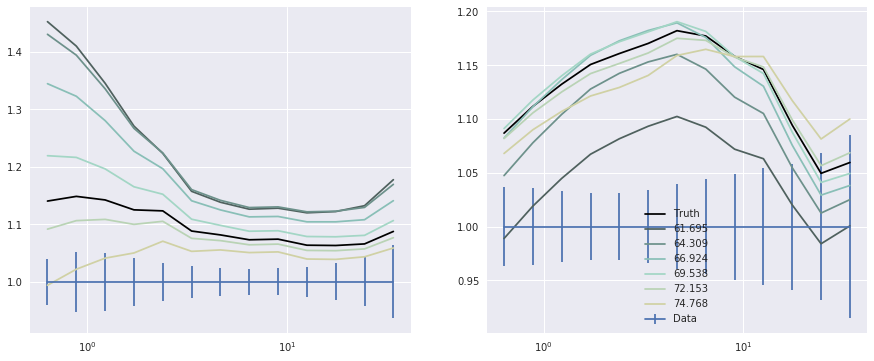

In [60]:
fig = plt.figure(figsize=(15,6))
varied_pname = 'H0'
lower, upper = emu.get_param_bounds(varied_pname)

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc[rmin_idxs], np.ones_like(true_data[i][rmin_idxs]),\
                 yerr=yerr[i][rmin_idxs]/true_data[i][rmin_idxs], label = 'Data')
    #pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    pred = emus[i].emulate_wrt_r(MAP_dict).squeeze()

    plt.plot(rbc[rmin_idxs], h_factor(MAP_dict['H0']/100)*(10**pred[rmin_idxs])/true_data[i][rmin_idxs], label = 'Truth', color = 'k')    

    plt.xscale('log')
    
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    #param_dict = true_param_dict.copy()
    param_dict=  MAP_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        plt.plot(rbc[rmin_idxs],h_factor(val/100)*(10**pred[rmin_idxs])/true_data[i][rmin_idxs], label = '%.3f'%val, color = c)
        #plt.plot(rbc[rmin_idxs], np.ones_like(pred[rmin_idxs]), color = c)
plt.legend(loc='best')
plt.show();

In [61]:
from pearce.mocks.kittens import TrainingBox

In [62]:
?? np.argmin

In [63]:
np.argmin(cat.cosmo_params['H0']), np.argmax(cat.cosmo_params['H0'])

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning:'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning:'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


(0, 4)

In [66]:
np.argsort(cat.cosmo_params['H0'])

#boxnum
0    0
1    1
2    6
3    2
4    5
5    3
6    4
Name: H0, dtype: int64

In [67]:
catlow, cathigh = TrainingBox(23), TrainingBox(17)

In [68]:
catlow.load(1.0, HOD='zheng07')

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/sim_manager/cached_halo_catalog.py:567: H5pyDeprecationWarning:The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


In [69]:
cathigh.load(1.0, HOD='zheng07')

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/sim_manager/cached_halo_catalog.py:567: H5pyDeprecationWarning:The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


In [70]:
catlow.populate(hod_params)

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/sim_manager/halo_table_cache_log_entry.py:404: H5pyDeprecationWarning:The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/sim_manager/halo_table_cache_log_entry.py:221: H5pyDeprecationWarning:The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for det

In [71]:
cathigh.populate(hod_params)

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/sim_manager/halo_table_cache_log_entry.py:404: H5pyDeprecationWarning:The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/halotools-0.7.dev5005-py2.7-linux-x86_64.egg/halotools/sim_manager/halo_table_cache_log_entry.py:221: H5pyDeprecationWarning:The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for det

In [72]:
rbins = np.logspace(-1.0, 1.6, 19)

In [73]:
wp_low_orig = catlow.calc_wp(rbins)

In [74]:
wp_high_orig = cathigh.calc_wp(rbins)

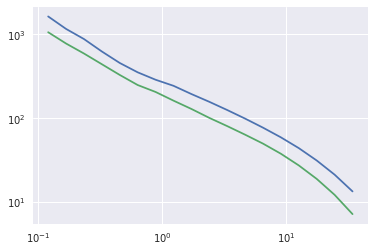

In [75]:
plt.plot(rbc, wp_low_orig)
plt.plot(rbc, wp_high_orig)
plt.loglog();
#plt.xscale('log')
plt.show()

In [76]:
lowh = catlow.h
highh = cathigh.h
catlow.h = 1
cathigh.h  =1

In [77]:
wp_low = catlow.calc_wp(rbins)

In [78]:
wp_high = cathigh.calc_wp(rbins)

In [85]:
h_factor = lambda h: h

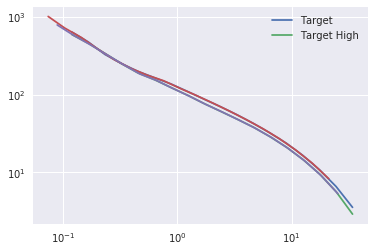

In [103]:
plt.plot(rbc, wp_low, label = 'Target')
plt.plot(rbc, wp_high, label = 'Target High')

plt.plot(rbc*lowh, lowh*wp_low_orig)
plt.plot(rbc*highh, highh*wp_high_orig)
plt.loglog();
#plt.xscale('log')
plt.legend(loc='best')
plt.show()